In [6]:
from cluster import KMeans, make_clusters
import numpy as np
from scipy.spatial.distance import cdist
from collections import defaultdict
from matplotlib import pyplot as plt

In [7]:
from cluster import KMeans
class Kplusplus(KMeans):
    def fit(self, mat: np.ndarray):
        """
        Fits the kmeans algorithm onto a provided 2D matrix.
        As a bit of background, this method should not return anything.
        The intent here is to have this method find the k cluster centers from the data
        with the tolerance, then you will use .predict() to identify the
        clusters that best match some data that is provided.

        In sklearn there is also a fit_predict() method that combines these
        functions, but for now we will have you implement them both separately.

        inputs:
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features
        """
        # Create an initial centroid
        self._generate_init_centroid(mat)

        # Generate k centroids
        self._generate_k_centroids(mat)

        # Calculate the sum of squares error for this first set of k centroids
        prev_error = self._generate_error_per_centroid(mat)

        # No other error here so set error_diff to prev_error
        curr_error = prev_error

        error_diff_dict = {}

        for key in curr_error:
            error_diff_dict[key] = np.absolute((prev_error[key])[0] - (curr_error[key])[0])

        # max_iter - 1 because already went through one iteration
        for i in range(self.max_iter-1):
            for values in error_diff_dict.values():
                if float(values) > self.tol:
                    self._update_centroids(mat)
                else:
                    break


    def predict(self, mat: np.ndarray) -> np.ndarray:
        """
        Predicts the cluster labels for a provided matrix of data points--
            question: what sorts of data inputs here would prevent the code from running?
            How would you catch these sorts of end-user related errors?
            What if, for example, the matrix is of a different number of features than
            the data that the clusters were fit on?

        inputs:
            mat: np.ndarray
                A 2D matrix where the rows are observations and columns are features

        outputs:
            np.ndarray
                a 1D array with the cluster label for each of the observations in `mat`
        """
        try:
            mat.ndim == 2
        except TypeError:
            print('Incorrect number of dimensions:' + mat.ndim)

        new_assign = self._assign_cluster(mat)

        for key, data_list in new_assign.items():
            key, values = zip(*data_list)  # Unpack
            plt.scatter(key, values, label=key)
        plt.show()

    def get_error(self) -> float:
        """
        Returns the final squared-mean error of the fit model. You can either do this by storing the
        original dataset or recording it following the end of model fitting.

        outputs:
            float
                the squared-mean error of the fit model
        """


    def get_centroids(self) -> np.ndarray:
        """
        Returns the centroid locations of the fit model.

        outputs:
            np.ndarray
                a `k x m` 2D matrix representing the cluster centroids of the fit model
        """
        return self.centroids

    def _generate_init_centroid(self, mat: np.ndarray):
        self.centroids = []
        initial_index = np.random.choice(range(mat.shape[0]), )
        self.centroids.append(mat[initial_index, :].tolist())

    def distance_from_centroids(self, mat: np.ndarray):
        centroids = self.centroids
        dist = cdist(mat, np.array(self.centroids))

        # Already calculating (minimum) distance between points in mat and closest centroid
        dist_squared = np.array([min([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat])
        self.dist_squared = dist_squared
        return self.dist_squared

    def _distance_from_centroids(self, mat: np.ndarray):
        centroids = self.centroids
        dist = cdist(mat, np.array(self.centroids))

        # Already calculating (minimum) distance between points in mat and closest centroid
        dist_squared = np.array([min([np.linalg.norm(m-c)**2 for c in centroids]) for m in mat])
        self.dist_squared = dist_squared

    def _choose_next_centroid(self, mat: np.ndarray):
        self.probs = self.dist_squared / self.dist_squared.sum()
        self.cumulative_probs = self.probs.cumsum()
        r = np.random.uniform(low=0.0, high=1.0)
        index = np.where(self.cumulative_probs >= r)[0][0]
        return mat[index]

    def _generate_k_centroids(self, mat: np.ndarray):
        self._generate_init_centroid(mat)
        while len(self.centroids) < self.k:
            self._distance_from_centroids(mat)
            self.centroids.append(self._choose_next_centroid(mat))
        self.centroids = np.array(self.centroids)

    def _determine_error(self, mat: np.ndarray) -> np.ndarray:
        centroids = self.get_centroids()
        sum_of_squares_error = np.array([np.square([np.sum((m-c)**2) for c in centroids]) for m in mat])
        return sum_of_squares_error

    def _assign_cluster(self, mat: np.ndarray) -> defaultdict:

        # I created a dictionary assigning each point to the centroid for which error is minimum
        assignment_dict = defaultdict(list)

        error = self._determine_error(mat)

        for index, val in enumerate(error):
            min_dist_index = np.argmin(error[index])
            assignment_dict[min_dist_index].append(mat[index])

        return assignment_dict

    def _update_centroids(self, mat: np.ndarray):
        # Creates a dictionary in which keys are centroids and values are the data points assigned to them
        class_dict = self._assign_cluster(mat)

        # Initialize a dictionary with mean coordinates for each cluster center
        mean_dict = defaultdict(list)

        # Iterate through the k keys
        for i in class_dict.keys():
            # Pass the values of class_dict into a list and assign to dict_values
            dict_values = list(class_dict.values())

            # Select the values corresponding to the ith key
            dict_values_curr = dict_values[i]

            # Take the mean of all the n observations and m features across each data point in a particular cluster
            dict_val_mean = map(np.mean, zip(*dict_values_curr))

            # Make dict_val_mean a list
            dict_val_mean = list(dict_val_mean)

            # Append mean_dict with the mean associated with the m and n values
            mean_dict[i].append(dict_val_mean)

        # Reset self.centroids to be empty
        self.centroids = []

        # Loop through the number of centroids until you have added k centroids
        while len(self.centroids) < self.k:

            # Iterate through mean_dict
            for key, value in mean_dict.items():
                # Assign the k key values to be indices for the self.centroids array
                index = key
                # Insert the associated mean values to a specific index
                self.centroids.insert(index, value)

        # Reshape self.centroids array to be m x n dimensions
        self.centroids = np.squeeze(np.array(self.centroids), axis=(1,))

    def _generate_error_per_centroid(self, mat: np.ndarray):
        # Returns dictionary of summed errors per cluster
        error_dict = defaultdict(list)
        error = self._determine_error(mat)
        for index, val in enumerate(error):
            min_dist_index = np.argmin(error[index])
            error_dict[min_dist_index].append(val[min_dist_index])

        # Calculate error of all assigned points in a particular cluster
        sum_errors_dict = {k: [sum(error_dict[k])] for k in error_dict.keys()}

        return sum_errors_dict

In [8]:
kmeansplusplus = Kplusplus(5, tol=1e-6, max_iter=100)
mat, labels = make_clusters(n=100000, m=2, k=5)

In [9]:
kmeansplusplus.fit(mat)

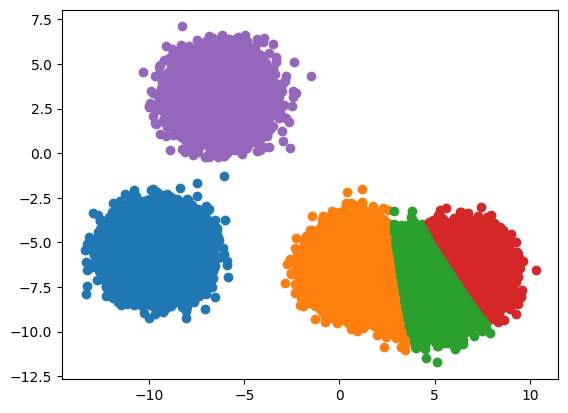

In [10]:
kmeansplusplus.predict(mat)